In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


import spacy
#python -m spacy download en_core_web_sm
import en_core_web_lg as mod
nlp = mod.load()

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
from spacy.vocab import Vocab


from sklearn.naive_bayes import MultinomialNB 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [25]:
#Read in Data
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")


#Visual Exploration
print(train_data.shape)
print(train_data.head(5))
train_data.keys()

#Label the keys
id_key=0
text_key=3
y_key=4


#collect the keywords
keywords=str(train_data.loc[train_data['target'] == 1].keyword.unique()).replace("'", "").replace('%20', " ").replace('nan', " ")
print(keywords)

(7613, 5)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
[  ablaze accident airplane accident ambulance annihilated
 annihilation apocalypse armageddon army arson arsonist
 attack attacked avalanche battle bioterror bioterrorism
 blaze blazing bleeding blew up blight blizzard blood
 bloody blown up body bag body bagging body bags bomb
 bombed bombing bridge collapse buildings burning
 buildings on fire burned burning burning buildings
 bush fires casualties casualty catastrophe catastrophic
 chemical emerge

In [21]:
#dis = nlp("disaster")

def preprocess_text(text):
        text.lower
        lemma_list=[]
        doc = nlp(text)
        for token in doc:
            if token.is_stop is False:
                lemma_list.append(token.lemma_)
#                 sim_score=token.similarity(dis)
#                 if sim_score > 0.3:
#                     lemma_list.append('diaster')
                            
        text=str(lemma_list)
        return text
    
def ff_preproc(train_data):
    keywords=preprocess_text(str(train_data.loc[train_data['target'] == 1].keyword.unique()).replace("'", "").replace('%20', " ").replace('nan', " "))  
    count_vect = CountVectorizer(preprocessor=preprocess_text) 
#   feature_frame=count_vect.fit_transform(df['text']).copy()
    count_vect.fit([keywords])
    return count_vect
    
def feature_frame_creator_disastertweets(df,count_vect):
    feature_frame=count_vect.transform(df['text']).copy()
    return feature_frame

In [22]:
#feature frame
FF_creator=feature_frame_creator_disastertweets
count_vect=ff_preproc(train_data)
feature_frame_train=FF_creator(df,count_vect)

#labels
y_labels=df[df.keys()[y_key]].copy()

#train test split
X_train, X_test, y_train, y_test = train_test_split(feature_frame_train,y_labels, random_state=0)

#select model
clf = MultinomialNB().fit(X_train, y_train) 

#score
print('Accuracy of classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(X_test,  y_test)))

# #predict
y_predict=clf.predict(FF_creator(test_data,count_vect)).copy()
print(y_predict)

# #output formating
sample_submission[df.keys()[y_key]]=y_predict

# print(output)
sample_submission.to_csv("submission.csv",index=0)

Accuracy of classifier on training set: 0.74
Accuracy of classifier on test set: 0.73
[1 1 1 ... 1 0 0]


**Aftermath**

Confusion matrix, without normalization
[[922 185]
 [332 465]]
Normalized confusion matrix
[[0.83 0.17]
 [0.42 0.58]]


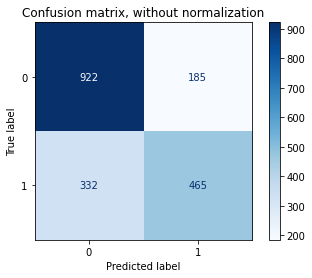

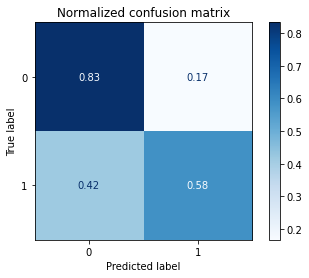

In [24]:
classifier=clf
class_names=['0','1']

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

This model correctly identifies the negative case better than it identifies the positive case, with a large fraction of false negatives.  For our purposes, perhaps it would be better to aim for no false negatives and accept more false posotove, so a real diaster tweet is not overlooked. 